In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

try:  # optional: only needed for the Gmsh-based mesher
    import gmsh  # type: ignore

    _HAS_GMSH = True
except Exception as exc:
    gmsh = None
    _HAS_GMSH = False
    print(f"gmsh is not available ({exc}). Falling back to the pure-Python mesher.")


def _configure_jax_platform(preferred: str = "gpu", fallback: str = "cpu") -> None:
    """Try the preferred accelerator, otherwise fall back to CPU."""
    try:
        devices = jax.devices(preferred)
    except RuntimeError:
        devices = []
    if devices:
        jax.config.update("jax_platform_name", preferred)
        print(f"JAX backend: {preferred} ({len(devices)} device(s) detected)")
    else:
        jax.config.update("jax_platform_name", fallback)
        print(f"JAX backend: {preferred} unavailable, falling back to {fallback}.")


_configure_jax_platform()
jax.devices()


JAX backend: gpu (1 device(s) detected)


W0103 09:25:03.382016   17274 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0103 09:25:03.383748   17214 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


[CudaDevice(id=0)]

## Load two images

Use the widgets below to upload a *reference* image (`im1`) and a *deformed* image (`im2`).
Both images are converted to grayscale and stored as JAX arrays so they can be reused in the next steps.

In [2]:
# Simple GUI: upload a reference image (im1) and a deformed image (im2),
# then preview them side-by-side.
import io
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def _to_gray_if_needed(arr):
    if arr is None:
        return None
    arr = np.asarray(arr)
    if arr.ndim == 3 and arr.shape[2] >= 3:
        return arr[..., :3].mean(axis=-1)
    return arr

def _set_image_from_array(arr, target='im1', path=None):
    arr = np.asarray(arr)
    arr = _to_gray_if_needed(arr)
    globals()[target] = jnp.array(arr)
    globals()[f'{target}_path'] = path
    _preview_images()

def _load_from_bytes(b, name=None, target='im1'):
    img = np.array(Image.open(io.BytesIO(b)))
    _set_image_from_array(img, target=target, path=name)

def _preview_images():
    with out:
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        imgs = [globals().get('im1', None), globals().get('im2', None)]
        paths = [globals().get('im1_path', None), globals().get('im2_path', None)]
        titles = ['Reference image (im1)', 'Deformed image (im2)']
        for ax, img, p, t in zip(axes, imgs, paths, titles):
            if img is None:
                ax.text(0.5, 0.5, f'No {t}', ha='center', va='center', fontsize=12)
                ax.set_axis_off()
            else:
                ax.imshow(np.asarray(img), cmap='gray', origin='lower')
                ax.set_title(f"{t}: {os.path.basename(p) if p else 'uploaded'}")
                ax.set_axis_off()
        plt.tight_layout()
        plt.show()

out = widgets.Output()

# Two upload widgets.
uploader_ref = widgets.FileUpload(accept='image/*', multiple=False, description='Upload reference (im1)')
uploader_def = widgets.FileUpload(accept='image/*', multiple=False, description='Upload deformed (im2)')

def _handle_upload(uploader, target):
    val = uploader.value
    if not val:
        return
    # different frontends may provide dict or tuple/list
    if isinstance(val, dict):
        fileinfo = list(val.values())[0]
    else:
        fileinfo = list(val)[0]
        if isinstance(fileinfo, str):
            fileinfo = val[fileinfo]
    content = fileinfo.get('content') or fileinfo.get('data')
    name = fileinfo.get('name') or getattr(fileinfo, 'name', None)
    if content is not None:
        _load_from_bytes(content, name=name, target=target)

def _on_ref_change(change):
    _handle_upload(uploader_ref, 'im1')

def _on_def_change(change):
    _handle_upload(uploader_def, 'im2')

uploader_ref.observe(_on_ref_change, names='value')
uploader_def.observe(_on_def_change, names='value')

# Layout: upload buttons on a single row, preview below
controls = widgets.HBox([
    widgets.VBox([widgets.HTML("<b>Reference (im1)</b>"), uploader_ref]),
    widgets.VBox([widgets.HTML("<b>Deformed (im2)</b>"), uploader_def])
])

display(widgets.VBox([controls, out]))

# Initial preview
_preview_images()


In [3]:
# ROI meshing from a binary mask.
# The GUI remains the same: upload a mask, adjust the element size, generate a mesh,
# and preview it over the reference image.
import io
from pathlib import Path

import meshio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output

from d2ic import mask_to_mesh_assets, mask_to_mesh_assets_gmsh

Path('SandBox').mkdir(exist_ok=True)
_mask_path = None
_mask_name = None

mask_uploader = widgets.FileUpload(accept='image/*', multiple=False, description='Upload mask (ROI)')
element_size = widgets.FloatSlider(value=20.0, min=2.0, max=150.0, step=1.0, description='Element size (px)')
approx_slider = widgets.FloatSlider(value=2.0, min=0.5, max=10.0, step=0.5, description='Contour step (px)')
generate_button = widgets.Button(description='Generate mesh', button_style='success', icon='check')
status_out = widgets.Output()
mask_preview = widgets.Output()
mesh_preview = widgets.Output()


def _mask_to_gray(arr: np.ndarray) -> np.ndarray:
    """Convert any PIL/NumPy mask array into a 2D grayscale image.

    Some image formats (e.g., LA) load as (H, W, 2) which Matplotlib cannot
    display with `imshow`. For ROI masks we also want to ignore alpha.
    """
    arr = np.asarray(arr)
    if arr.ndim == 2:
        return arr
    if arr.ndim != 3 or arr.shape[-1] < 1:
        raise TypeError(f"Invalid shape {arr.shape} for mask data")
    channels = arr.shape[-1]
    if channels == 1:
        return arr[..., 0]
    if channels in (2, 4):
        # L+A or RGB+A: keep luminance/RGB but ignore alpha.
        return arr[..., 0] if channels == 2 else arr[..., :3].mean(axis=-1)
    return arr[..., :3].mean(axis=-1)


def _extract_payload(val):
    if not val:
        return None
    if isinstance(val, dict):
        return list(val.values())[0]
    if isinstance(val, (list, tuple)):
        entry = val[0]
        if isinstance(entry, str):
            entry = val[entry]
        return entry
    entry = list(val)[0]
    if isinstance(entry, str):
        entry = val[entry]
    return entry


def _handle_mask_upload(change):
    global _mask_path, _mask_name
    payload = _extract_payload(mask_uploader.value)
    mask_preview.clear_output()
    status_out.clear_output()
    if not payload:
        _mask_path = None
        _mask_name = None
        return
    data = payload.get('content') or payload.get('data')
    name = payload.get('name') or 'mask.png'
    if data is None:
        return
    suffix = Path(name).suffix or '.png'
    _mask_path = Path('SandBox') / f'roi_mask_uploaded{suffix}'
    _mask_path.write_bytes(data)
    _mask_name = name
    mask_img = np.array(Image.open(io.BytesIO(data)))
    mask_img_gray = _mask_to_gray(mask_img)
    with mask_preview:
        clear_output(wait=True)
        plt.figure(figsize=(4, 4))
        plt.imshow(mask_img_gray, cmap='gray', origin='lower')
        plt.title(f"Mask: {name}")
        plt.axis('off')
        plt.show()


mask_uploader.observe(_handle_mask_upload, names='value')


def _plot_mesh_on_reference(mesh_path: Path):
    with mesh_preview:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(5, 5))
        ref_img = globals().get('im1')
        if ref_img is not None:
            ax.imshow(np.asarray(ref_img), cmap='gray', origin='lower')
            ax.set_xlim(0, ref_img.shape[1])
            ax.set_ylim(0, ref_img.shape[0])
        else:
            ax.set_facecolor('0.95')
            ax.text(0.5, 0.5, "Please upload a reference image first (im1)", ha='center', va='center')
        try:
            # `.msh` is ambiguous (can be Gmsh or Ansys). We force the Gmsh reader
            # because this notebook writes Gmsh-compatible `.msh` files.
            mesh = meshio.read(str(mesh_path), file_format='gmsh')
        except Exception:
            # Fallback: avoid file parsing and rebuild a meshio object from
            # the in-memory `d2ic` mesh.
            d2ic_mesh = globals().get('_d2ic_mesh')
            if d2ic_mesh is None:
                raise
            nodes_xy = np.asarray(d2ic_mesh.nodes_xy)
            points = np.column_stack([
                nodes_xy,
                np.zeros((nodes_xy.shape[0],), dtype=nodes_xy.dtype),
            ])
            cells = [(
                'quad',
                np.asarray(d2ic_mesh.elements, dtype=np.int32),
            )]
            mesh = meshio.Mesh(points=points, cells=cells)
        surface_cells = None
        for block in mesh.cells:
            if block.type in ('quad', 'triangle') and block.data.size:
                surface_cells = block.data
                break
        if surface_cells is None:
            ax.text(0.5, 0.5, 'Mesh has no surface elements', ha='center', va='center')
        else:
            nodes = mesh.points[:, :2]
            polys = nodes[surface_cells]
            collection = PolyCollection(polys, facecolors='none', edgecolors='tab:red', linewidths=1.2)
            ax.add_collection(collection)
            ax.set_aspect('equal')
        ax.set_title('Mesh overlay on the reference image')
        plt.show()


def _generate_mesh(_):
    status_out.clear_output()
    mesh_preview.clear_output()
    if _mask_path is None:
        with status_out:
            print("Please upload a binary ROI mask before generating the mesh.")
        return
    msh_path = Path('roi_mesh.msh')
    try:
        mask_img = np.array(Image.open(_mask_path))
        mask_gray = _mask_to_gray(mask_img)
        mask = np.asarray(mask_gray) > 0

        # Prefer the Gmsh-based mesher when available (better boundaries),
        # but keep a pure-Python fallback so the notebook remains usable.
        try:
            mesh, assets = mask_to_mesh_assets_gmsh(
                mask=mask,
                element_size_px=float(element_size.value),
                contour_step_px=float(approx_slider.value),
                binning=1,
                remove_islands=True,
                min_island_area_px=64,
            )
            mesher = 'gmsh'
        except Exception:
            mesh, assets = mask_to_mesh_assets(
                mask=mask,
                element_size_px=float(element_size.value),
                binning=1,
                remove_islands=True,
                min_island_area_px=64,
            )
            mesher = 'python'

        # Persist the mesh as a .msh file so the GUI preview (meshio) can read it.
        nodes_xy = np.asarray(mesh.nodes_xy)
        points = np.column_stack([nodes_xy, np.zeros((nodes_xy.shape[0],), dtype=nodes_xy.dtype)])
        elements = np.asarray(mesh.elements, dtype=np.int32)
        meshio_mesh = meshio.Mesh(points=points, cells=[('quad', elements)])
        meshio.write(str(msh_path), meshio_mesh, file_format='gmsh')

        # Store in globals so the next cells can directly use the in-memory objects.
        globals()['_d2ic_mesh'] = mesh
        globals()['_d2ic_assets'] = assets
    except Exception as exc:
        with status_out:
            print(f"Mesh generation failed: {exc}")
        return
    with status_out:
        print(
            f"Mesh saved: {msh_path.resolve()} (h={element_size.value:.1f}px, contour_step={approx_slider.value:.1f}px, mesher={mesher})"
        )
    _plot_mesh_on_reference(msh_path)


generate_button.on_click(_generate_mesh)

display(widgets.VBox([
    widgets.HTML("<b>1) Upload a binary ROI mask (white ROI / black background)</b>"),
    mask_uploader,
    mask_preview,
    widgets.HTML("<b>2) Set parameters and generate the mesh</b>"),
    widgets.HBox([element_size, approx_slider]),
    generate_button,
    status_out,
    mesh_preview,
]))



## DIC

This section runs a **single-pair** DIC analysis:
1) build pixel-level precomputations (mapping pixels → mesh elements),
2) compute a coarse initial guess (optional),
3) run the global solver and (optionally) a local refinement.

In [4]:
from pathlib import Path

import meshio
import numpy as np

from d2ic import DICMeshBased, Mesh, MeshDICConfig
from d2ic.mesh_assets import make_mesh_assets
from d2ic.solver_global_cg import GlobalCGSolver


def _load_d2ic_mesh_from_msh(mesh_path: Path) -> Mesh:
    msh = meshio.read(str(mesh_path))
    cells = msh.cells_dict
    if 'quad' in cells:
        elements = cells['quad']
    elif 'triangle' in cells:
        elements = cells['triangle']
    else:
        raise ValueError(f"Unsupported cell types in mesh: {list(cells)}")
    nodes_xy = msh.points[:, :2]
    return Mesh(nodes_xy=jnp.asarray(nodes_xy), elements=jnp.asarray(elements.astype(np.int32)))


mesh_file = Path('roi_mesh.msh')
if mesh_file.exists():
    print(f"Mesh file found: {mesh_file.resolve()}")
else:
    print("No 'roi_mesh.msh' detected. Generate it from the mask before continuing.")

# Reuse the in-memory mesh/assets if the GUI cell has been executed.
mesh = globals().get('_d2ic_mesh', None)
assets = globals().get('_d2ic_assets', None)
if mesh is None:
    if not mesh_file.exists():
        raise FileNotFoundError("Missing roi_mesh.msh and no in-memory mesh is available.")
    mesh = _load_d2ic_mesh_from_msh(mesh_file)
if assets is None:
    assets = make_mesh_assets(mesh, with_neighbors=True)

# Build the DIC pipeline (refactored `d2ic` stack).
ref_image = np.asarray(im1, dtype=float)
img = np.asarray(im1)
config = MeshDICConfig(max_iters=50, tol=1e-6, reg_strength=0.0, strain_gauge_length=100.0)
dic_study = DICMeshBased(mesh=mesh, solver=GlobalCGSolver(interpolation='cubic'), config=config)
dic_study.prepare(ref_image=ref_image, assets=assets)

# Keep the prepared assets (now including pixel precomputations) for later cells.
assets = dic_study._state.assets  # noqa: SLF001
globals()['_d2ic_mesh'] = mesh
globals()['_d2ic_assets'] = assets


Mesh file found: /workspaces/08_dic/D2IC/doc/roi_mesh.msh


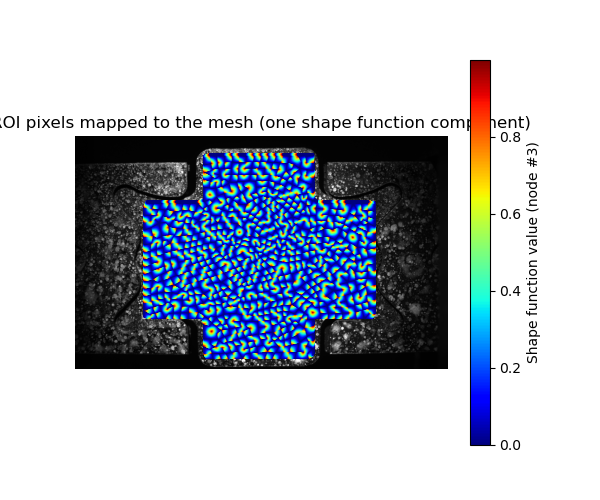

In [7]:
# Visual sanity check: plot one shape function value for each pixel in the ROI.
pix = globals()['_d2ic_assets'].pixel_data
N = np.asarray(pix.pixel_shapeN)[:, 2]
coords = np.asarray(pix.pixel_coords_ref)

plt.figure(figsize=(6, 5))
plt.imshow(img, cmap='gray', origin='lower')
plt.scatter(coords[:, 0], coords[:, 1], s=1, c=N, cmap='jet')
plt.colorbar(label='Shape function value (node #3)')
plt.title('ROI pixels mapped to the mesh (one shape function component)')
plt.axis('off')
plt.show()

In [5]:
# Coarse initial guess (optional): translation-only ZNCC matching around element centers.
# This replaces the legacy feature/RANSAC initializer.
import numpy as np

from d2ic import DICInitMotion, InitMotionConfig
from d2ic.solver_translation_zncc import TranslationZNCCSolver

assets = globals()['_d2ic_assets']
im1b = np.asarray(im1, dtype=float)
im2b = np.asarray(im2, dtype=float)

init_cfg = InitMotionConfig(win=13, search=101, score_min=0.2)
dic_init = DICInitMotion(init_cfg, TranslationZNCCSolver(init_cfg))
dic_init.prepare(ref_image=im1b, assets=assets)

# Nodal initial guess (IDW projection of center matches).
init_result = dic_init.run(im2b)
disp_guess = np.asarray(init_result.u_nodal, dtype=float)
disp_guess.mean(axis=0)

# Extra diagnostics: keep the raw center matches and their ZNCC scores for plotting.
sol = dic_init.solver.solve(dic_init._state, im2b)  # noqa: SLF001
extras = {
    'centers_xy': np.asarray(assets.element_centers_xy),
    'u_centers': np.asarray(sol.u_centers),
    'scores': np.asarray(sol.scores),
}


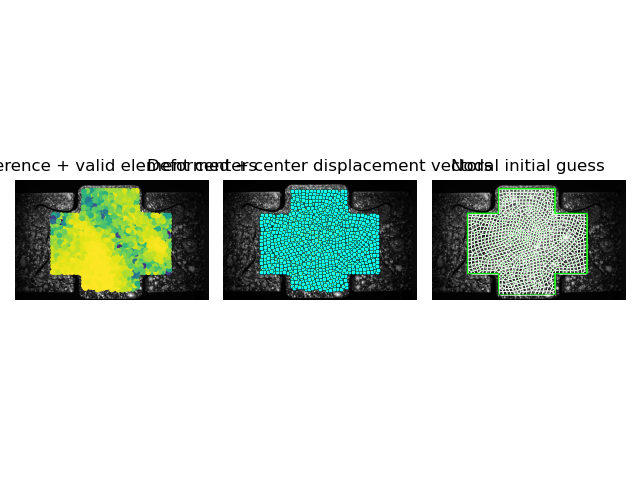

In [10]:
from matplotlib.collections import LineCollection

centers = np.asarray(extras['centers_xy'])
u_centers = np.asarray(extras['u_centers'])
scores = np.asarray(extras['scores'])

mesh = globals()['_d2ic_mesh']
nodes = np.asarray(mesh.nodes_xy)
elements = np.asarray(mesh.elements, dtype=int)

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)

ax = axes[0]
ax.imshow(im1, cmap="gray", origin='lower')
valid = np.isfinite(scores)
ax.scatter(centers[valid, 0], centers[valid, 1], s=10, c=scores[valid], cmap='viridis')
ax.set_title("Reference + valid element centers")
ax.set_axis_off()

ax = axes[1]
ax.imshow(im2, cmap="gray", origin='lower')
ax.scatter(centers[valid, 0], centers[valid, 1], s=10, c='cyan', edgecolor='k', linewidth=0.3)
ax.quiver(
    centers[valid, 0],
    centers[valid, 1],
    u_centers[valid, 0],
    u_centers[valid, 1],
    angles="xy",
    scale_units="xy",
    scale=1.0,
    color="yellow",
    width=0.002,
)
ax.set_title("Deformed + center displacement vectors")
ax.set_axis_off()

ax = axes[2]
ax.imshow(im1, cmap="gray", origin='lower', alpha=1.0)
polys = nodes[elements]
segments = []
for poly in polys:
    loop = np.vstack([poly, poly[0]])
    segments.extend(np.stack([loop[:-1], loop[1:]], axis=1))
line_collection = LineCollection(segments, colors="white", linewidths=0.5)
ax.add_collection(line_collection)
ax.quiver(
    nodes[:, 0],
    nodes[:, 1],
    disp_guess[:, 0],
    disp_guess[:, 1],
    color="lime",
    angles="xy",
    scale_units="xy",
    scale=1.0,
    width=0.003,
    zorder=5,
)
ax.set_title("Nodal initial guess")
ax.set_axis_off()

for ax in axes:
    ax.set_aspect("equal")

fig.tight_layout()
plt.show()

## Image binning (optional)

If your images are very large, you can downsample them before running DIC.
This notebook keeps the full resolution for clarity.

In [6]:
displacement = np.asarray(disp_guess, dtype=float)

In [7]:
im1b = np.asarray(im1, dtype=float)
im2b = np.asarray(im2, dtype=float)

In [8]:
from d2ic import DICMeshBased, MeshDICConfig
from d2ic.solver_global_cg import GlobalCGSolver

mesh = globals()['_d2ic_mesh']
assets = globals()['_d2ic_assets']

cfg_quick = MeshDICConfig(max_iters=30, tol=1e-2, reg_strength=0.05, strain_gauge_length=100.0)
dic_study = DICMeshBased(mesh=mesh, solver=GlobalCGSolver(interpolation='cubic'), config=cfg_quick)
dic_study.prepare(ref_image=im1b, assets=assets)
dic_study.set_initial_guess(jnp.asarray(displacement))
result = dic_study.run(im2b)
displacement = np.asarray(result.u_nodal)
globals()['_d2ic_assets'] = dic_study._state.assets  # noqa: SLF001
globals()['_last_result'] = result


In [9]:
# Global DIC solve (CG + spring regularization).

from d2ic import DICMeshBased, MeshDICConfig
from d2ic.solver_global_cg import GlobalCGSolver

mesh = globals()['_d2ic_mesh']
assets = globals()['_d2ic_assets']

displacement_init = np.asarray(displacement, dtype=float)
cfg = MeshDICConfig(max_iters=500, tol=1e-3, reg_strength=100.0, strain_gauge_length=100.0)
dic_study = DICMeshBased(mesh=mesh, solver=GlobalCGSolver(interpolation='cubic'), config=cfg)
dic_study.prepare(ref_image=im1b, assets=assets)
dic_study.set_initial_guess(jnp.asarray(displacement_init))
result = dic_study.run(im2b)
displacement = np.asarray(result.u_nodal)
globals()['_d2ic_assets'] = dic_study._state.assets  # noqa: SLF001
globals()['_last_result'] = result


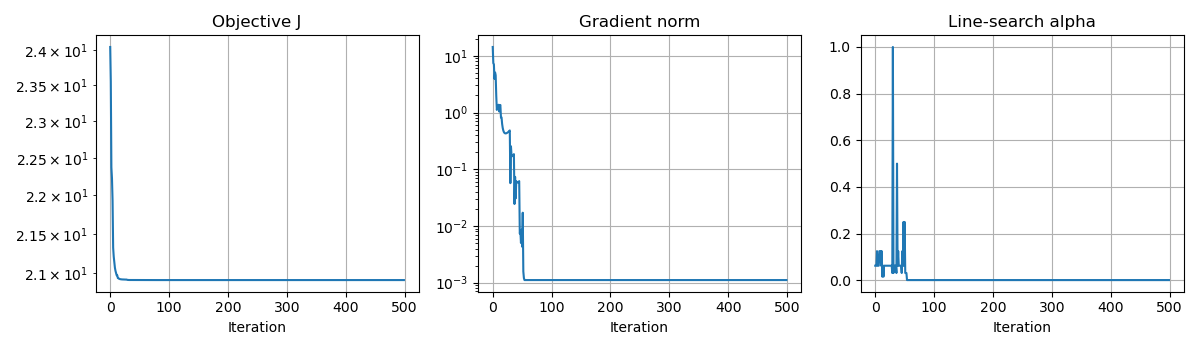

In [10]:
# Convergence history
# The refactored solvers can return a per-iteration history in `result.history`.
# For the CG solver, the columns are: [objective J, ||grad||, line-search alpha].
import numpy as np

result = globals().get('_last_result', None)
history = getattr(result, 'history', None) if result is not None else None

if history is None:
    print('No history available (result.history is None).')
else:
    hist = np.asarray(history)
    valid = np.isfinite(hist[:, 0])
    it = np.arange(hist.shape[0])[valid]
    J = hist[valid, 0]
    g = hist[valid, 1]
    a = hist[valid, 2]

    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
    axes[0].plot(it, J)
    axes[0].set_yscale('log')
    axes[0].set_title('Objective J')
    axes[0].set_xlabel('Iteration')
    axes[0].grid(True)

    axes[1].plot(it, g)
    axes[1].set_yscale('log')
    axes[1].set_title('Gradient norm')
    axes[1].set_xlabel('Iteration')
    axes[1].grid(True)

    axes[2].plot(it, a)
    axes[2].set_title('Line-search alpha')
    axes[2].set_xlabel('Iteration')
    axes[2].grid(True)

    fig.tight_layout()
    plt.show()


In [12]:
# Optional local refinement: local Gauss-Newton sweeps.
from d2ic import DICMeshBased, MeshDICConfig
from d2ic.solver_local_gn import LocalGaussNewtonSolver

mesh = globals()['_d2ic_mesh']
assets = globals()['_d2ic_assets']

cfg_local = MeshDICConfig(max_iters=7, tol=1e-3, reg_strength=1000.0, strain_gauge_length=100.0)
dic_local = DICMeshBased(
    mesh=mesh,
    solver=LocalGaussNewtonSolver(lam=0.1, max_step=0.2, omega=0.5, interpolation='cubic'),
    config=cfg_local,
)
dic_local.prepare(ref_image=im1b, assets=assets)
dic_local.set_initial_guess(jnp.asarray(displacement))
result_local = dic_local.run(im2b)
displacement = np.asarray(result_local.u_nodal)
globals()['_d2ic_assets'] = dic_local._state.assets  # noqa: SLF001
globals()['_last_result'] = result_local


## Post-processing

Compute strain measures from the final displacement field and visualize the results.

In [13]:
from d2ic.strain import compute_green_lagrange_strain_nodes_lsq

assets = globals()['_d2ic_assets']

F_all, E_all = compute_green_lagrange_strain_nodes_lsq(
    displacement=jnp.asarray(displacement),
    nodes_coord=assets.mesh.nodes_xy,
    node_neighbor_index=assets.node_neighbor_index,
    node_neighbor_degree=assets.node_neighbor_degree,
    gauge_length=100.0,
)


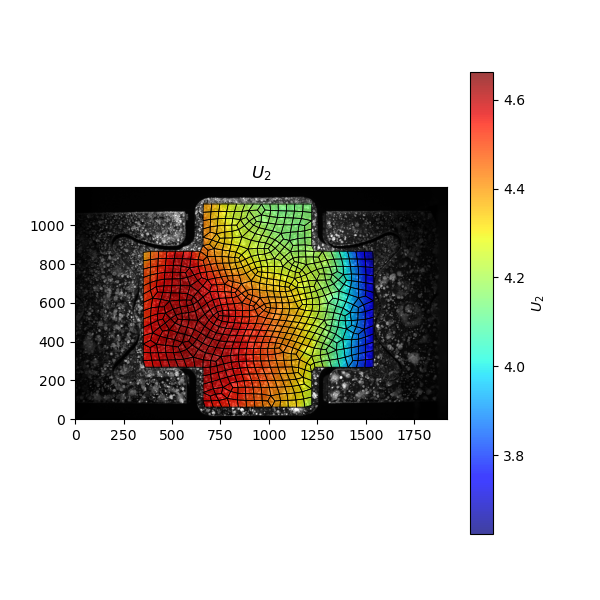

In [14]:
import numpy as np

from d2ic import DICPlotter, DICResult, DICDiagnostics

mesh = globals()['_d2ic_mesh']
result_for_plot = DICResult(
    u_nodal=jnp.asarray(displacement),
    strain=jnp.asarray(E_all),
    diagnostics=DICDiagnostics(info={'source': 'notebook'}),
)

plotter = DICPlotter(
    result=result_for_plot,
    mesh=mesh,
    def_image=np.asarray(im2b),
    ref_image=np.asarray(im1b),
    project_on_deformed='fast',
)
fig, ax = plotter.plot(field='uy')


In [ ]:
# Minimal interactive GUI around the new plotter.
import ipywidgets as widgets
from IPython.display import display, clear_output


def _show_interactive(plotter):
    field = widgets.Dropdown(
        options=[
            ('U1', 'u1'),
            ('U2', 'u2'),
            ('E11', 'e11'),
            ('E22', 'e22'),
            ('E12', 'e12'),
            ('Discrepancy', 'discrepancy'),
        ],
        value='u2',
        description='Field',
    )
    alpha = widgets.FloatSlider(value=0.75, min=0.0, max=1.0, step=0.05, description='Alpha')
    cmap = widgets.Dropdown(options=['jet', 'viridis', 'plasma', 'coolwarm'], value='jet', description='Colormap')
    plotmesh = widgets.Checkbox(value=True, description='Show mesh')
    out = widgets.Output()

    def _update(*_):
        with out:
            clear_output(wait=True)
            plotter.plot(field=field.value, image_alpha=alpha.value, cmap=cmap.value, plotmesh=plotmesh.value)
            plt.show()

    for w in (field, alpha, cmap, plotmesh):
        w.observe(_update, names='value')

    display(widgets.VBox([widgets.HBox([field, cmap, alpha, plotmesh]), out]))
    _update()


_show_interactive(plotter)
